<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 2. Preprocessing Waktu
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
# 3. Fitur Musiman/Event
df['is_ramadan'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2023) & (df['bulan'].isin([3, 4]))) |
    ((df['tahun'] == 2024) & (df['bulan'].isin([3, 4])))
).astype(int)

df['is_lebaran'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 5)) |
    ((df['tahun'] == 2023) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2024) & (df['bulan'] == 4))
).astype(int)

df['is_libur_sekolah'] = df['bulan'].isin([6, 7]).astype(int)
df['is_akhir_tahun'] = (df['bulan'] == 12).astype(int)

In [6]:
# 4. Label Encoding Kategori
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])
le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])
le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

In [7]:
# 5. Filter Pengeluaran Saja
df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [8]:
# 6. Agregasi Bulanan per User
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()

agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [9]:
# 7. Fitur Derivatif Rolling/statistik
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values
agg['rolling3_std'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).std().shift(1).values
agg['rolling3_min'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).min().shift(1).values
agg['rolling3_max'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).max().shift(1).values
agg['trend_bulan'] = (agg['total_pengeluaran'] - agg['pengeluaran_bulan_lalu']) / (agg['pengeluaran_bulan_lalu'] + 1)
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [10]:
# 8. Fitur Musiman/Event di agg
agg['is_ramadan'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2023) & (agg['bulan'].isin([3, 4]))) |
    ((agg['tahun'] == 2024) & (agg['bulan'].isin([3, 4])))
).astype(int)
agg['is_lebaran'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 5)) |
    ((agg['tahun'] == 2023) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2024) & (agg['bulan'] == 4))
).astype(int)
agg['is_libur_sekolah'] = agg['bulan'].isin([6, 7]).astype(int)
agg['is_akhir_tahun'] = (agg['bulan'] == 12).astype(int)

In [11]:
# 9. Drop NA Baris
agg = agg.dropna(subset=[
    'target', 'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan'
]).reset_index(drop=True)

In [12]:
# 10. Split Train/Test
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

In [13]:
# 11. Daftar Fitur Full
fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan',
    'is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [14]:
# 12. Target Log Transform
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [15]:
# 13. Hyperparameter XGBoost
param_grid = {
    'n_estimators': [80, 100, 120, 140, 160],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.08, 0.1, 0.12, 0.15],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [3, 5, 7, 10],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=60,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_log)
print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters found:
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.12, 'gamma': 7, 'colsample_bytree': 0.9}


In [16]:
# 14. Evaluasi Model XGBoost
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
mask = y_test > 200000
if mask.sum() > 0:
    mape_200k = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE (target > 200k): {mape_200k:.2f}%")
else:
    print("Tidak ada data target > 200 ribu.")

MAE: 5940091.78
RMSE: 10220430.87
MAPE: 391.71%
MAPE (target > 200k): 146.76%


In [17]:
# 15. Baseline (Naive)
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}, Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAE: 8093284.09, Baseline MAPE: 674.36%


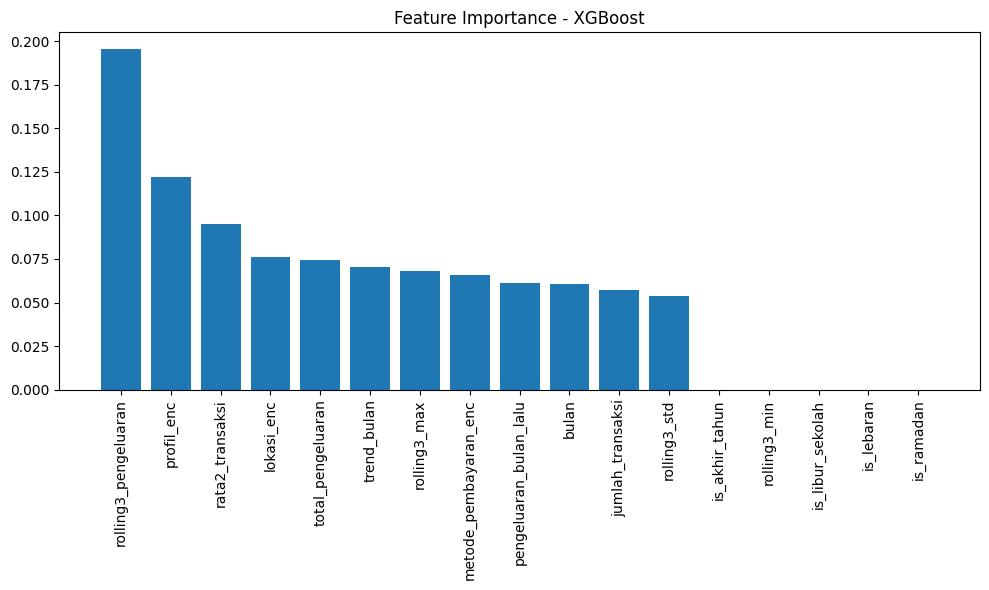

1. rolling3_pengeluaran: 0.1953
2. profil_enc: 0.1220
3. rata2_transaksi: 0.0951
4. lokasi_enc: 0.0759
5. total_pengeluaran: 0.0746
6. trend_bulan: 0.0705
7. rolling3_max: 0.0679
8. metode_pembayaran_enc: 0.0659
9. pengeluaran_bulan_lalu: 0.0614
10. bulan: 0.0609
11. jumlah_transaksi: 0.0573
12. rolling3_std: 0.0535
13. is_akhir_tahun: 0.0000
14. rolling3_min: 0.0000
15. is_libur_sekolah: 0.0000
16. is_lebaran: 0.0000
17. is_ramadan: 0.0000


In [18]:
# 16. Feature Importance
importances = best_model.feature_importances_
feature_names = fitur
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importance - XGBoost")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
for f in range(len(importances)):
    print(f"{f+1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")

In [19]:
# 17. Model Sederhana (Hanya Event & Kategori)
fitur_simple = [
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun'
]
X_train_simple = train[fitur_simple]
X_test_simple = test[fitur_simple]
xgb_simple = XGBRegressor(random_state=42, n_jobs=-1)
xgb_simple.fit(X_train_simple, y_train_log)
y_pred_simple_log = xgb_simple.predict(X_test_simple)
y_pred_simple = np.expm1(y_pred_simple_log)
mae_simple = mean_absolute_error(y_test, y_pred_simple)
mape_simple = np.mean(np.abs((y_test - y_pred_simple) / y_test)) * 100
print(f"Model Simple MAE: {mae_simple:.2f}, MAPE: {mape_simple:.2f}%")
importances_simple = xgb_simple.feature_importances_
for f, imp in zip(fitur_simple, importances_simple):
    print(f"{f}: {imp:.4f}")

Model Simple MAE: 7844414.35, MAPE: 759.00%
profil_enc: 0.3212
metode_pembayaran_enc: 0.1084
lokasi_enc: 0.1146
bulan: 0.1416
is_ramadan: 0.1278
is_lebaran: 0.1143
is_libur_sekolah: 0.0721
is_akhir_tahun: 0.0000


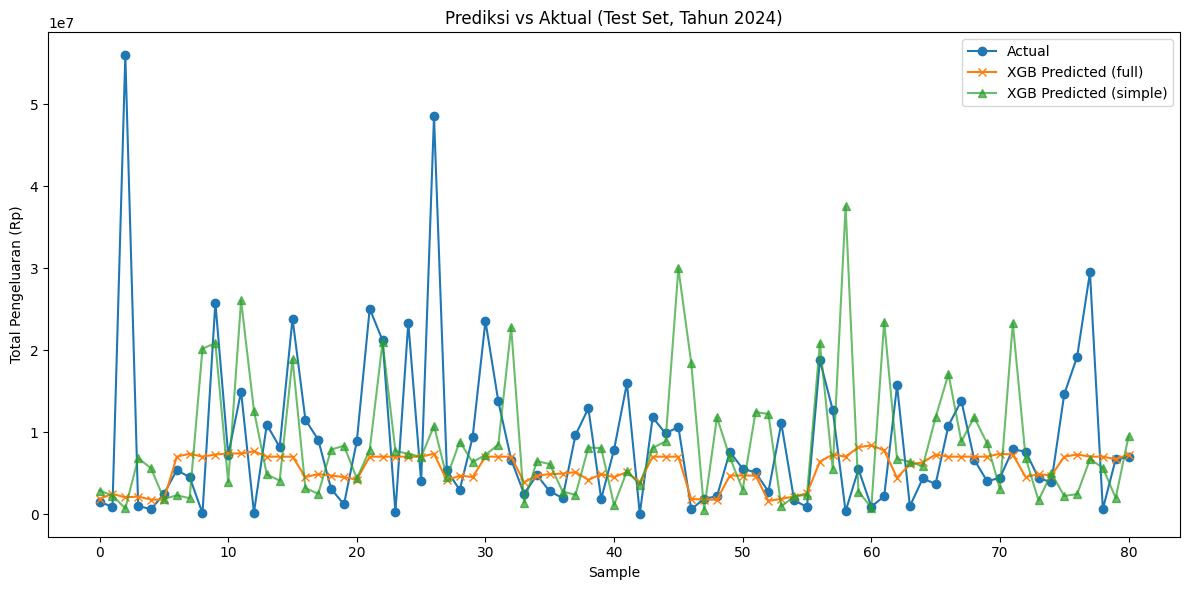

In [20]:
# 18. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='XGB Predicted (full)', marker='x')
plt.plot(y_pred_simple, label='XGB Predicted (simple)', marker='^', alpha=0.7)
plt.legend()
plt.title('Prediksi vs Aktual (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()

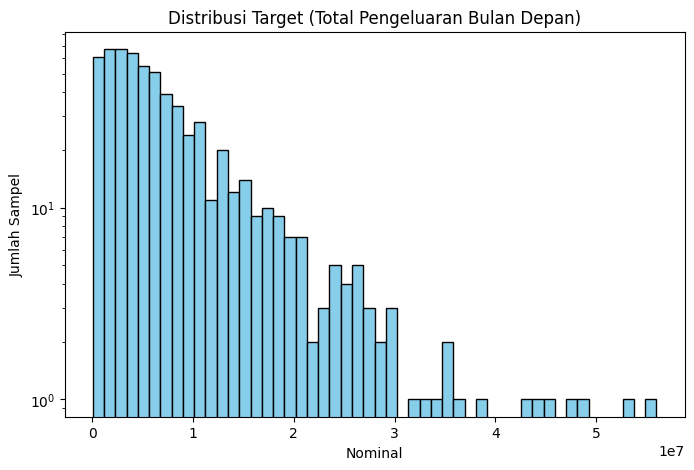

is_ramadan:
is_ramadan
0    524
1    106
Name: count, dtype: int64


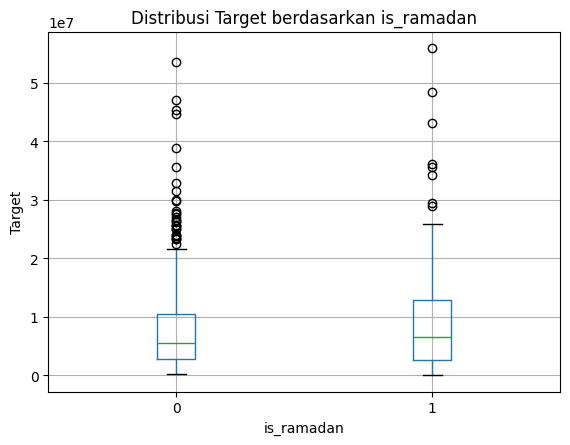

is_lebaran:
is_lebaran
0    574
1     56
Name: count, dtype: int64


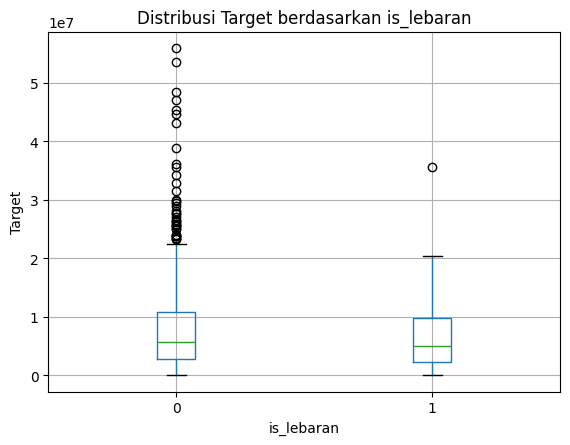

is_libur_sekolah:
is_libur_sekolah
0    530
1    100
Name: count, dtype: int64


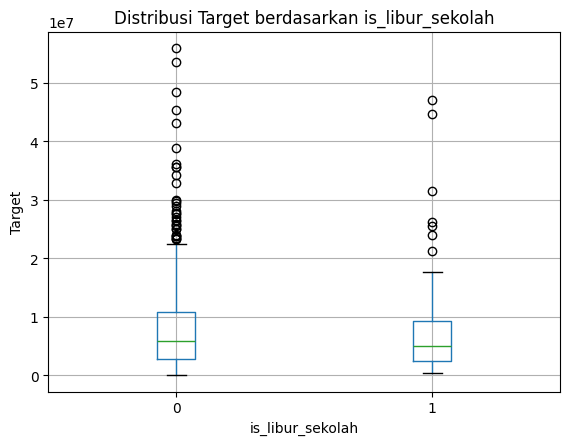

is_akhir_tahun:
is_akhir_tahun
0    580
1     50
Name: count, dtype: int64


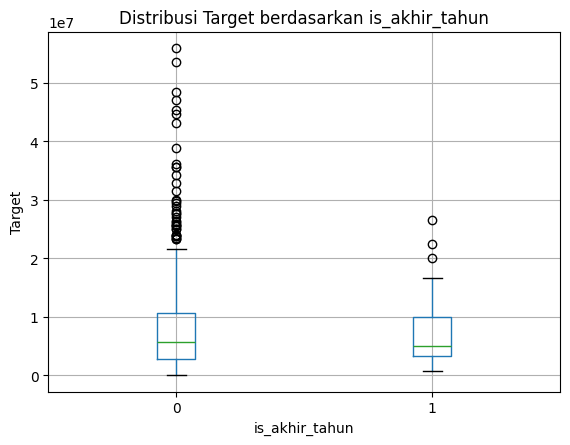

In [21]:
# 19. Distribusi Target & Event
plt.figure(figsize=(8,5))
plt.hist(agg['target'], bins=50, color='skyblue', edgecolor='k')
plt.title('Distribusi Target (Total Pengeluaran Bulan Depan)')
plt.xlabel('Nominal')
plt.ylabel('Jumlah Sampel')
plt.yscale('log')
plt.show()

for event in ['is_ramadan', 'is_lebaran', 'is_libur_sekolah', 'is_akhir_tahun']:
    print(f"{event}:")
    print(agg[event].value_counts())
    agg.boxplot(column='target', by=event)
    plt.title(f"Distribusi Target berdasarkan {event}")
    plt.suptitle('')
    plt.xlabel(event)
    plt.ylabel('Target')
    plt.show()